In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import data_table
# Display smart tables into colab ;-)
data_table.enable_dataframe_formatter()

# Data collect

In [3]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test = pd.read_csv('/content/sample_data/california_housing_test.csv')
all_data = pd.concat([train, test], axis=0)

In [4]:
all_data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [5]:
all_data.shape

(20000, 9)

In [10]:
all_data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object

In [5]:
all_data

Output hidden; open in https://colab.research.google.com to view.

# Check null values & first data views

In [1]:
all_data.isnull().sum()

NameError: ignored

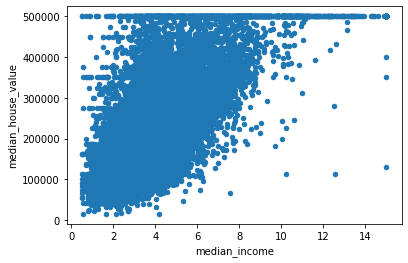

In [7]:
all_data.plot.scatter("median_income", "median_house_value")

We clearly see a relationship between median_income & median_house_value (not perfect of course) 

# Prepare data

First we need to scale the data & prepare the global dataset

In [8]:
scaler = StandardScaler()
def prepare_data(data, scale=True):
  names = data.columns
  if (scale == True):
    scaled_data = scaler.fit_transform(data)
    data = pd.DataFrame(scaled_data, columns=names)
  #X_features = ["median_income", "latitude", "longitude", "housing_median_age", "total_bedrooms", "total_rooms", "population", "households"] 
  y_label = ["median_house_value"]
  X = data[names]
  del X["median_house_value"]
  y = data[y_label]
  x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=1)
  return x_train,x_test,y_train,y_test

In [9]:
x_train, x_test, y_train, y_test = prepare_data(all_data)

# 1) "Classic" Regression

In [10]:
model_1_regression = LinearRegression()
model_1_regression.fit(x_train, y_train)
y_test_prediction = model_1_regression.predict(x_test)
print(f"Score / training data: {round(model_1_regression.score(x_train, y_train)*100, 1)} %")
print(f"Score / test data: {round(model_1_regression.score(x_test, y_test)*100, 1)} %")

Score / training data: 64.2 %
Score / test data: 62.3 %


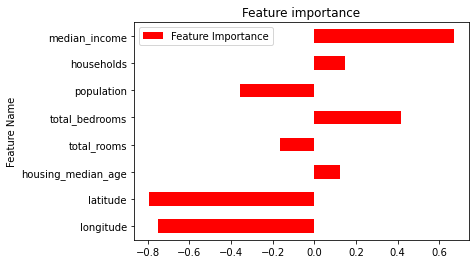

In [11]:
def display_feat_imp_reg(reg):
  feat_imp_reg = model_1_regression.coef_[0]
  reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
  reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
  reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
  reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

display_feat_imp_reg(model_1_regression)

# 2) Random forest

## Without changing the dataset

In [12]:
model_2_rforest = RandomForestRegressor()
model_2_rforest.fit(x_train, y_train)
print(f"Score / training data: {round(model_2_rforest.score(x_train, y_train)*100, 1)} %")
print(f"Score / test data: {round(model_2_rforest.score(x_test, y_test)*100, 1)} %")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Score / training data: 97.5 %
Score / test data: 81.0 %


In [13]:
y_test_prediction = model_2_rforest.predict(x_test)
mean_squared_error(y_test_prediction, y_test)

0.18629173357002946

97% is definitely a too good score comparing to the test data (81%) ! we overfit here ... but why ?

   Feature Importance        Feature Name
7            0.520823       median_income
0            0.160318           longitude
1            0.150686            latitude
2            0.063610  housing_median_age
5            0.034908          population
4            0.026310      total_bedrooms
3            0.024800         total_rooms
6            0.018545          households


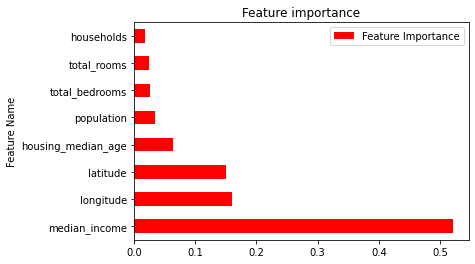

In [14]:
def display_feat_imp_rforest(rforest):
  feat_imp = rforest.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = x_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

display_feat_imp_rforest(model_2_rforest)

Clearly the feature median_income takes a very important place in the final decision (52%)

# 3) XGBoost

In [15]:
model_3_xgboost = XGBRegressor(n_estimators=50, 
                     max_depth=7, 
                     eta=0.1, 
                     subsample=0.7, 
                     colsample_bytree=0.8, 
                     objective ='reg:squarederror')
model_3_xgboost.fit(x_train, y_train)
scores = cross_val_score(model_3_xgboost, x_train, y_train,cv=10)
print("Training Data Mean cross-validation score: %.2f" % scores.mean())
scores = cross_val_score(model_3_xgboost, x_test, y_test,cv=10)
print("Test Data Mean cross-validation score: %.2f" % scores.mean())

Training Data Mean cross-validation score: 0.83
Test Data Mean cross-validation score: 0.78


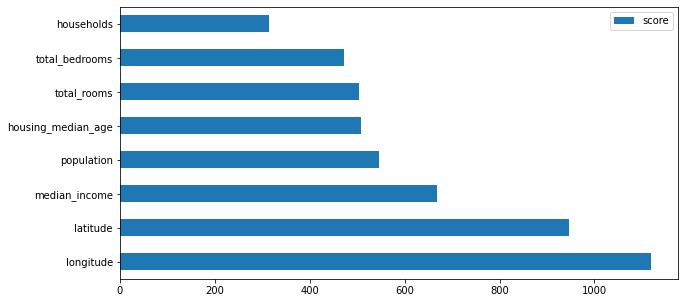

In [16]:
def display_feat_imp_rforest(model):
  feature_imp = model_3_xgboost.get_booster().get_score(importance_type='weight')
  keys = list(feature_imp.keys())
  values = list(feature_imp.values())
  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
  data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5)) 

display_feat_imp_rforest(model_3_xgboost)